# Land Carbon Sink Analysis

Main notebook for the Land Carbon Sink Analysis project.

In [231]:
import xarray as xr
import matplotlib
import xesmf as xe
import numpy as np
import pandas as pd
import polars as pl
import os, sys

In [232]:
# directories
rawDir = "../data/raw/"
interimDir = "../data/interim/"
processedDir = "../data/processed/"

## Net Land-use Flux

In [3]:
# National land use change carbon emissions ['Summary', 'BLUE', 'H&C2023', 'OSCAR']
nluc = pl.read_excel(
    rawDir + "National_LandUseChange_Carbon_Emissions_2023v1.0.xlsx",
    sheet_id=2,
    read_options={"header_row": 7},
    has_header=0,
)
nluc.head()

unit: Tg C/year,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Botswana,Brazil,Brunei Darussalam,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Central African Republic,Chad,Chile,China,…,South Sudan,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Syria,Tajikistan,Thailand,Timor-Leste,Togo,Tonga,Trinidad and Tobago,Tunisia,Türkiye,Turkmenistan,Tuvalu,Uganda,Ukraine,United Arab Emirates,United Kingdom,Tanzania,USA,Uruguay,Uzbekistan,Vanuatu,Vatican City,Venezuela,Viet Nam,Yemen,Zambia,Zimbabwe,OTHER,DISPUTED,Global,EU27
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""QF""",1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,…,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
"""1850""",0.81321,0.35006,1.3491,0.0056,2.42807,-0.00222,3.15928,0.17596,2.41452,1.08449,0.85176,0.0006,0.0,4.81875,0.01646,10.81258,1.24621,0.04652,-1.36558,0.13964,7.03278,1.02102,0.08413,11.24974,0.01408,1.15645,0.13244,0.45949,0.33528,0.94758,19.73677,0.00653,0.30411,2.38661,2.50938,64.75003,…,1.31066,8.25594,6.39086,0.41039,0.05917,6.33314,1.01622,0.2111,0.14773,5.44597,0.52221,0.13251,0.00669,0.29177,0.13148,4.05924,0.14281,0,1.5229,13.7545,-0.0002,2.32986,2.37006,220.15201,0.24275,0.52615,0.01398,0.00001,13.8727,5.1552,-0.15362,2.8091,0.22792,0.01569,0.42685,989.03703,95.33341
"""1851""",0.81928,0.36496,1.32128,0.00473,2.42977,-0.00393,3.28472,0.17582,2.71252,1.06181,0.84572,0.00064,0.0,4.02972,0.0154,10.822,1.24206,0.10955,-1.37469,0.32481,10.14895,1.00515,0.08423,12.22678,-0.01237,1.05056,0.13652,0.45413,0.30871,0.82311,19.80653,0.00665,0.28336,3.79434,2.58041,64.37465,…,1.30551,7.75396,5.93256,0.39427,0.05801,6.38944,1.00094,0.21172,0.14892,6.93277,0.56196,0.12506,0.00659,0.26722,0.13673,4.06812,0.14422,0,1.37743,14.9705,-0.00021,1.56048,2.12809,236.7311,0.35285,0.53124,0.0078,0.00001,16.91828,5.45471,-0.15613,2.70464,0.22459,0.01461,0.61147,1039.62828,93.85074
"""1852""",0.82466,0.3788,1.30517,0.00415,2.46422,-0.00547,3.29216,0.17614,2.96212,1.05418,0.84089,0.00068,0.0,3.77321,0.01485,10.86556,1.17393,0.06239,-1.38575,0.16973,11.98688,1.02707,0.08418,10.64325,-0.0038,0.98014,0.13494,0.45724,0.28953,0.57793,22.80865,0.00672,0.22063,4.72838,2.64438,62.24161,…,1.30136,7.47281,5.64669,0.38996,0.05898,6.4624,1.00337,0.21186,0.14976,7.66162,0.5831,0.11461,0.00642,0.25655,0.1399,4.07304,0.14505,0,1.3259,15.88161,-0.00022,0.70421,2.03147,244.76757,0.45218,0.53449,0.00644,0.00001,17.99017,5.15271,-0.15834,2.76771,0.22112,0.01433,0.36787,1065.75318,93.05538
"""1853""",0.82924,0.38932,1.29503,0.00369,2.47617,-0.00688,3.31606,0.17661,3.09466,1.04186,0.83819,0.00069,0.0,3.65993,0.01448,10.80604,1.27642,0.17646,-1.39734,0.17814,13.33429,1.0499,0.08406,11.33311,0.00137,0.92497,0.13092,0.43305,0.2924,0.61655,24.19316,0.00675,0.21442,5.41144,2.75901,61.85008,…,1.29812,7.27195,5.45361,0.3805,0.05794,6.49285,1.04869,0.21176,0.15027,7.1364,0.60121,0.10331,0.0063,0.2513,0.14196,4.07067,0.14559,0,1.28171,16.57404,-0.00023,0.43365,1.96437,256.98638,0.52857,0.53678,0.00631,0.00001,19.47363,5.43101,-0.16043,2.75974,0.23146,0.01406,0.46614,1094.90553,92.06626


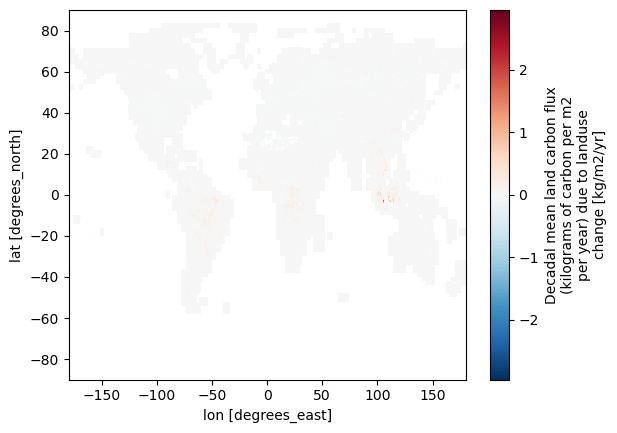

In [4]:
# Land use change carbon emissions (0.25 arcdegrees)
lucGrid = xr.open_dataset(
    rawDir + "Landuse_carbon_flux_gridded_GCB2023_2013-2022_mean.nc"
)
lucGrid.Landuse_Cflux.plot()

## Natural Land Sink

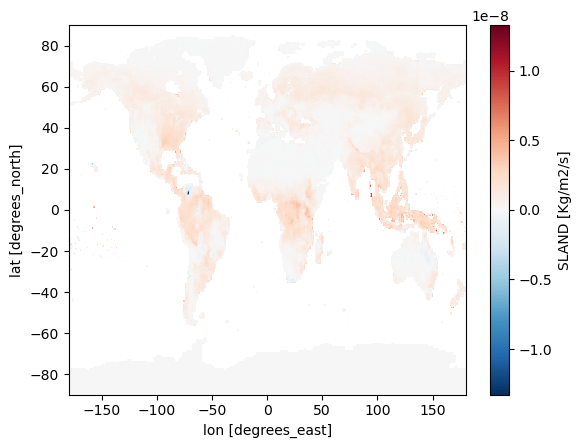

In [233]:
# Natural Land Sink (0.5 arcdegrees)
natLandSink = xr.open_dataset(
    rawDir + "Land_carbon_uptake_DGVMs_gridded_GCB2023_2013-2022_mean.nc"
)
natLandSink.SLAND.plot()

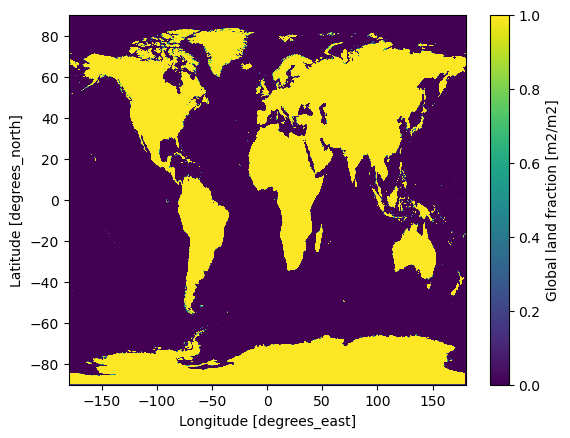

In [247]:
# Country mask (0.1 arcdegrees)
countryMask = xr.open_dataset(
    rawDir + "Country-mask_UNFCCC_layers-all-countries_grid-3600x1800.nc"
)

countryMask.land_fraction_global.plot()

In [7]:
print(countryMask)

<xarray.Dataset> Size: 10GB
Dimensions:               (lon: 3600, lat: 1800, ISOcode: 199)
Coordinates:
  * lon                   (lon) float64 29kB -179.9 -179.8 ... 179.9 180.0
  * lat                   (lat) float64 14kB -89.95 -89.85 ... 89.85 89.95
  * ISOcode               (ISOcode) float64 2kB 4.0 24.0 ... 9.999e+03 5.555e+03
Data variables:
    land_fraction         (ISOcode, lat, lon) float64 10GB ...
    land_fraction_global  (lat, lon) float64 52MB ...
Attributes:
    CDI:                   Climate Data Interface version 2.0.3 (https://mpim...
    Conventions:           CF-1.6
    CDO:                   Climate Data Operators version 2.0.3 (https://mpim...
    ISO_code_explanation:  4: AFG, 24: AGO, 8: ALB, 20: AND, 784: ARE, 32: AR...


### Regrid countryMask to Match natLandSink Resolution

In [8]:
# Inspect the coordinates
print(natLandSink.coords)
print(countryMask.coords)

Coordinates:
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
Coordinates:
  * lon      (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.9 180.0
  * lat      (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * ISOcode  (ISOcode) float64 2kB 4.0 24.0 8.0 ... 716.0 9.999e+03 5.555e+03


In [9]:
# Regrid `countryMask` to match `natLandSink` coordinates
regridder = xe.Regridder(countryMask, natLandSink, method="conservative")
countryMask_regridded = regridder(countryMask)

In [10]:
countryMask_regridded.to_netcdf(interimDir + "countryMask_regridded.nc")

In [234]:
# Inspect the coordinates
print(countryMask_regridded)

<xarray.Dataset> Size: 415MB
Dimensions:               (ISOcode: 199, lat: 360, lon: 720)
Coordinates:
  * ISOcode               (ISOcode) float64 2kB 4.0 24.0 ... 9.999e+03 5.555e+03
  * lon                   (lon) float64 6kB -179.8 -179.2 -178.8 ... 179.2 179.8
  * lat                   (lat) float64 3kB -89.75 -89.25 -88.75 ... 89.25 89.75
Data variables:
    land_fraction         (ISOcode, lat, lon) float64 413MB ...
    land_fraction_global  (lat, lon) float64 2MB 0.9664 0.9664 ... 0.0 0.0
Attributes:
    regrid_method:  conservative


In [235]:
# Load datasets
countryMask_regridded = xr.open_dataset(interimDir + "countryMask_regridded.nc")
country_codes = pd.read_excel(rawDir + "Country-codes_UNFCCC_199countries.xlsx")
country_codes["Numeric"] = country_codes["Numeric"].astype(int)

# Get list of country codes
ctrs_UNFCCC = country_codes["Alpha-3"]

In [236]:
# Get lat and lon names
if "latitude" in natLandSink.dims:
    lat_name, lon_name = "latitude", "longitude"
else:
    lat_name, lon_name = "lat", "lon"

# Check that model grid and country grid agree
check_lat1 = np.max(
    np.abs(natLandSink[lat_name].values - countryMask_regridded[lat_name].values)
)
check_lon1 = np.max(
    np.abs(natLandSink[lon_name].values - countryMask_regridded[lon_name].values)
)
if check_lat1 > 0.001 or check_lon1 > 0.001:
    sys.exit("Coordinates do not agree")

# Re-index if there are small deviations in lat and lon
if (check_lat1 != 0) or (check_lon1 != 0):
    countryMask_regridded = countryMask_regridded.reindex(
        {lat_name: natLandSink[lat_name], lon_name: natLandSink[lon_name]},
        method="nearest",
    )

In [237]:
help(xe.util.cell_area)

Help on function cell_area in module xesmf.util:

cell_area(ds, earth_radius=None)
    Get cell area of a grid, assuming a sphere.

    Parameters
    ----------
    ds : xarray Dataset
        Input grid, longitude and latitude required.
        Curvilinear coordinate system also require cell bounds to be present.
    earth_radius : float, optional
        Earth radius, assuming a sphere, in km.

    Returns
    -------
    area : xarray DataArray
        Cell area. If the earth radius is given, units are km^2, otherwise they are steradian (sr).



In [238]:
# Compute grid areas (in km^2) for natLandSink
grid_areas_km2 = xe.util.cell_area(
    natLandSink, earth_radius=6371.0
)  # Earth radius in km

# Convert km^2 to m²
grid_areas_m2 = grid_areas_km2 * 1_000_000  # 1 km^2 = 1,000,000 m²

# Convert kgC/m²/s to GtC/year (global scale)
# Scale factor calculation
natLandSink = natLandSink.SLAND * 1e-12 * (60 * 60 * 24 * 365) * grid_areas_m2
natLandSink = natLandSink.fillna(0)

In [239]:
# Dictionary for storing country data
data_ctrs = dict()

# Loop over all country codes
for i, iso_alpha3 in enumerate(ctrs_UNFCCC):

    if np.mod(i, 20) == 0:
        print(f"  - processing country {i + 1} of {len(ctrs_UNFCCC)}")

    # Get numeric ISO code for the country
    iso_numeric = country_codes["Numeric"][
        country_codes["Alpha-3"] == iso_alpha3
    ].values[0]

    # Extract country mask for the current country
    mask = countryMask_regridded.sel(ISOcode=iso_numeric)

    # Weight by fraction of country-specific land area
    weights = mask.land_fraction / mask.land_fraction_global

    # Sum up the natural land sink for the selected country
    data_sel = (natLandSink * weights).sum((lat_name, lon_name))

    # Store results in dictionary
    data_ctrs[iso_alpha3] = data_sel.values

  - processing country 1 of 199
  - processing country 21 of 199
  - processing country 41 of 199
  - processing country 61 of 199
  - processing country 81 of 199
  - processing country 101 of 199
  - processing country 121 of 199
  - processing country 141 of 199
  - processing country 161 of 199
  - processing country 181 of 199


In [240]:
data_ocean = natLandSink.where(countryMask_regridded.land_fraction_global == 0)
data_ocean = data_ocean.where(data_ocean != 0)

In [241]:
# Get 2D arrays with latitudes and longitudes and only keep country areas (where land_fraction exists)
LON, LAT = np.meshgrid(countryMask_regridded.lon, countryMask_regridded.lat)

# Mask out ocean areas where land_fraction is NaN (i.e., only keep country areas)
LAT[countryMask_regridded.land_fraction_global == 0] = np.nan
LON[countryMask_regridded.land_fraction_global == 0] = np.nan

In [242]:
# Convert latitudes and longitudes to radians for distance calculation
LAT_rad = LAT * np.pi / 180
LON_rad = LON * np.pi / 180

In [243]:
# Loop over all ocean grid cells to assign values to closest country cells
for i_lat in range(len(data_ocean.lat)):
    for i_lon in range(len(data_ocean.lon)):
        # Read land sink data for the specific grid cell
        data_sel = data_ocean.isel(lat=i_lat, lon=i_lon)

        # Only process ocean grid cells with non-zero land sink values
        if not np.isnan(data_sel):

            # Get latitude and longitude of the ocean grid cell in radians
            lat_ocean = data_sel.lat.item() * np.pi / 180
            lon_ocean = data_sel.lon.item() * np.pi / 180

            # Calculate the argument for arccos
            argument = np.sin(lat_ocean) * np.sin(LAT_rad) + np.cos(lat_ocean) * np.cos(
                LAT_rad
            ) * np.cos(lon_ocean - LON_rad)
            argument = np.clip(argument, -1, 1)  # Clip to avoid invalid values

            # Calculate distances
            distance = np.arccos(argument)

            # Find the closest land grid cell(s)
            index_closest = np.argwhere(distance == np.nanmin(distance))

            for ind in index_closest:
                # Get latitude and longitude of the closest grid cell
                lat_sel = LAT[ind[0], ind[1]]
                lon_sel = LON[ind[0], ind[1]]

                # Select the land_fraction at the specified lat, lon
                land_fraction_at_point = countryMask_regridded.sel(
                    lat=lat_sel, lon=lon_sel
                ).land_fraction

                # Find the index where land_fraction is non-zero
                non_zero_index = np.where(land_fraction_at_point.values != 0)[0]

                # There should only be one non-zero value, retrieve the corresponding ISOcode
                if len(non_zero_index) == 1:
                    iso_code = countryMask_regridded.ISOcode[non_zero_index[0]].values
                    print(f"ISO Code for the given lat, lon: {iso_code}")
                else:
                    print("No or multiple countries found for this lat, lon")

                # Retrieve country name for the ISO code
                ctr_name = country_codes["Alpha-3"][
                    country_codes["Numeric"] == iso_code
                ].values[0]

                # Add the ocean grid cell's natural land sink value to the closest country's data
                data_ctrs[ctr_name] += data_sel.values / len(index_closest)

ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0
ISO Code for the given lat, lon: 5555.0


In [244]:
# Convert data_ctrs to a DataFrame with country names as the index
data_ctrs_df = pd.DataFrame(list(data_ctrs.items()), columns=["iso", "Land_Sink"])

# Sort the DataFrame by 'Country' column if needed
data_ctrs_df = data_ctrs_df.sort_values("Land_Sink").reset_index(drop=True)

# Add units to the DataFrame and save to Excel
data_ctrs_df.to_excel(processedDir + "land_sink_by_country.xlsx", index=False)

data_ctrs_df.to_csv(processedDir + "land_sink_by_country.csv")

In [245]:
total_land_sink_Gt_per_yr = data_ctrs_df["Land_Sink"].sum()
Sland_sum = (natLandSink).sum(dim=["lat", "lon"]).item()
print(
    "Country Sum Land Sink (Gt per yr) conservative method:", total_land_sink_Gt_per_yr
)

print("Total Grid Cell Sum Land Sink (Gt per yr) :", Sland_sum)

Country Sum Land Sink (Gt per yr) conservative method: 4.2994323607677405
Total Grid Cell Sum Land Sink (Gt per yr) : 4.2994323607677405


check if the sum of the land fraction over all countries equals the total land fraction in the remapped country mask

In [248]:
# Calculate the total land fraction in the remapped country mask
total_land_fraction_regridded = (
    countryMask_regridded["land_fraction_global"].sum().item()
)

# Calculate the summed land fraction over all countries
total_land_fraction_countries = (
    countryMask_regridded["land_fraction"].sum(dim=["ISOcode", "lat", "lon"]).item()
)

# Print both values to check if they are equal
print(f"Total land fraction in remapped mask: {total_land_fraction_regridded}")
print(
    f"Summed land fraction over all countries (remapped mask): {total_land_fraction_countries}"
)

# Compare the values with a small tolerance due to floating-point precision
if abs(total_land_fraction_regridded - total_land_fraction_countries) < 1e-6:
    print(
        "The sum of land fractions over all countries is approximately equal to the total land fraction in the remapped mask."
    )
else:
    print("The sums do not match, indicating a discrepancy.")

# Calculate the total land fraction in the original country mask
total_land_fraction_original = countryMask["land_fraction_global"].sum().item()
print(f"Total land fraction (original): {total_land_fraction_original}")

Total land fraction in remapped mask: 86188.53286568244
Summed land fraction over all countries (remapped mask): 86188.5328656824
The sum of land fractions over all countries is approximately equal to the total land fraction in the remapped mask.
Total land fraction (original): 2152311.9827217525


## Fossil and Industry CO2 emissions

## Inclusive Wealth Calculations

### Country Social Cost of Carbon

In [ ]:
# Read the CSV using pandas
cscc = pd.read_csv(
    rawDir + "statscc_SSP2_rcp60_constant_estimates_climensemble_hmqrs_lineartrend.csv",
    na_values=["NA"],  # Use na_values instead of null_values in pandas
)

# Show the first few rows to check
print(cscc.head())

       mean       10%       25%       50%       75%       90%            ID  \
0  0.005771  0.002139  0.003110  0.004218  0.007508  0.012430  2_1p5_NA_AFG   
1  0.193915  0.146453  0.161908  0.185704  0.224977  0.246136  2_1p5_NA_AGO   
2  0.003214  0.001607  0.002301  0.002832  0.004133  0.005066  2_1p5_NA_ALB   
3  0.899642  0.671506  0.718220  0.820168  1.066469  1.239778  2_1p5_NA_ARE   
4  0.207296  0.101300  0.159885  0.200887  0.264989  0.304651  2_1p5_NA_ARG   

   iso   dr elasmu  prtp  
0  AFG  NaN    1p5   2.0  
1  AGO  NaN    1p5   2.0  
2  ALB  NaN    1p5   2.0  
3  ARE  NaN    1p5   2.0  
4  ARG  NaN    1p5   2.0  


In [ ]:
# Get unique ISO codes from both DataFrames
cscc_iso = cscc["iso"].unique()  # Extract unique ISO codes from cscc DataFrame
country_sums_iso = data_ctrs_df[
    "iso"
].unique()  # Extract unique ISO codes from data_ctrs_df

# Find ISO codes present in both DataFrames
common_iso = list(set(cscc_iso).intersection(country_sums_iso))
print("ISO codes present in both DataFrames:")
print(common_iso)

# Find ISO codes only in cscc (without a match in country_sums_df_cons)
cscc_only_iso = list(set(cscc_iso) - set(country_sums_iso))
print("Countries only in cscc (ISO codes):")
print(cscc_only_iso)

# Find countries only in country_sums_df_cons
country_sums_only_countries = list(set(country_sums_iso) - set(cscc_iso))
print("Countries only in country_sums_df:")
print(country_sums_only_countries)

ISO codes present in both DataFrames:
['DOM', 'SVK', 'ROU', 'VNM', 'AGO', 'MRT', 'AZE', 'JPN', 'CAN', 'QAT', 'SLB', 'BEN', 'POL', 'FJI', 'PAN', 'ARG', 'USA', 'THA', 'MOZ', 'LUX', 'LVA', 'GEO', 'AFG', 'KGZ', 'SLE', 'SYR', 'LBR', 'GMB', 'GHA', 'BRA', 'ARE', 'AUS', 'KHM', 'BRN', 'JOR', 'ZAF', 'GRC', 'CMR', 'TZA', 'MDA', 'ERI', 'KEN', 'NER', 'EST', 'ESP', 'LAO', 'COD', 'ISL', 'MMR', 'BIH', 'SVN', 'CAF', 'NZL', 'RWA', 'KAZ', 'PRY', 'UGA', 'DJI', 'GNB', 'MAR', 'GIN', 'ARM', 'GUY', 'ZMB', 'NOR', 'SRB', 'BDI', 'BTN', 'HTI', 'IRN', 'TJK', 'CHL', 'MLI', 'ETH', 'PAK', 'ISR', 'BEL', 'BGD', 'SLV', 'BLZ', 'SWE', 'TCD', 'TUR', 'LTU', 'NGA', 'TUN', 'FRA', 'HND', 'BHS', 'COM', 'UKR', 'BFA', 'PHL', 'GBR', 'JAM', 'MNE', 'SDN', 'KOR', 'SWZ', 'MDG', 'TGO', 'MUS', 'VUT', 'ITA', 'ZWE', 'MEX', 'TKM', 'BLR', 'UZB', 'LBN', 'KWT', 'COG', 'CYP', 'GNQ', 'MNG', 'NLD', 'IRQ', 'NIC', 'HUN', 'PNG', 'DNK', 'CPV', 'CRI', 'NPL', 'FIN', 'IRL', 'CIV', 'YEM', 'GTM', 'DZA', 'SEN', 'GAB', 'MWI', 'COL', 'IDN', 'BWA', 'DEU', 'L

### EXKURS:

In [132]:
terrestrial_sink = pd.read_excel(
    rawDir + "Global_Carbon_Budget_2023v1.1.xlsx",
    sheet_name="Terrestrial Sink",
    header=27,
)  # Row 28 has column names

# Drop column 'C' since it is empty
terrestrial_sink = terrestrial_sink.drop(columns=["Unnamed: 2"])

# View the resulting DataFrame
print(terrestrial_sink.head())

# Filter the DataFrame for the years 2013 to 2022
filtered_terrestrial_sink = terrestrial_sink[
    (terrestrial_sink["Year"] >= 2013) & (terrestrial_sink["Year"] <= 2022)
]

# Calculate the mean of the 'GCB' column for the filtered years
mean_gcb = filtered_terrestrial_sink["GCB"].mean()

   Year       GCB  CABLE-POP  CLASSIC    CLM5.0      DLEM        ED       ELM  \
0  1959  0.430359  -0.297389   0.3162  0.276912  0.434518  0.711015  0.864334   
1  1960  1.252347   2.137762   1.1037  1.790785  1.671215  1.142080  1.738872   
2  1961  0.899620   1.676709   0.8056  0.885000  1.341876  2.086029  1.270117   
3  1962  1.293962   1.831520   1.0017  0.334234  1.855886  1.718834  1.641357   
4  1963  0.959732   1.392875   0.0056  1.719622  1.172225  1.306013  1.397455   

       IBIS      ISAM  ...     LPJml  LPX-Bern     OCNv2  ORCHIDEE-v3  \
0  0.568455  1.483840  ...  0.039440  0.328832  0.889957     0.549868   
1  1.084692  1.341953  ...  1.572189  0.689288  1.060378     1.176620   
2  0.559826  0.957341  ...  0.131270  0.437127  1.466082     0.856589   
3  0.961032  1.470531  ...  1.058574  0.165028  1.700229     1.542580   
4  0.323399  1.156859  ...  0.328858  0.215212  1.540279     0.770386   

      SDGVM  VISIT     YIBs  Unnamed: 23  Multi-model mean  Model Spread (

In [133]:
print(mean_gcb)

3.3490033956991168
